# Results Analysis on JudgeBench

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Analysis

In [5]:
# Define file paths for evaluation results
file_paths = {
    "Single": ["single_1.csv", "single_2.csv"],
    "Parallel": ["parallel_1.csv", "parallel_2.csv"],
    "Cooperative": ["cooperative_1.csv", "cooperative_2.csv"],
    "Competitive": ["competitive_1.csv", "competitive_2.csv"]
}

# Load evaluation results
data = {}
for system, paths in file_paths.items():
    df1 = pd.read_csv(f"Results/{paths[0]}")
    df2 = pd.read_csv(f"Results/{paths[1]}")
    data[system] = {"_1": df1, "_2": df2}

# Collect evaluation metrics
results = []

for system, dfs in data.items():
    df1, df2 = dfs["_1"], dfs["_2"]

    # Calculate accuracy (only valid A/B decisions)
    acc_1 = df1[df1["system_decision"].isin(["A", "B"])]["is_correct"].mean()
    acc_2 = df2[df2["system_decision"].isin(["A", "B"])]["is_correct"].mean()
    acc_avg = (acc_1 + acc_2) / 2

    # Calculate proportion of invalid "X" responses
    x_1 = (df1["system_decision"] == "X").mean()
    x_2 = (df2["system_decision"] == "X").mean()

    # Consistency analysis (only rows with valid A/B decisions in both versions)
    valid_mask = df1["system_decision"].isin(["A", "B"]) & df2["system_decision"].isin(["A", "B"])
    valid_rows = df1[valid_mask].copy()
    matching = df2[valid_mask]["system_decision"].reset_index(drop=True)

    # Compare decisions to check consistency despite swapping
    s1 = valid_rows["system_decision"].reset_index(drop=True)
    s2 = df2[valid_mask]["system_decision"].reset_index(drop=True)
    consistent = s1 == s2
    inconsistency_rate = 1 - consistent.mean()

    results.append({
        "System": system,
        "Accuracy (normal)": round(acc_1, 3),
        "Accuracy (swapped)": round(acc_2, 3),
        "Accuracy (avg)": round(acc_avg, 3),
        "Inconsistency": round(inconsistency_rate, 3),
        "X rate (normal)": round(x_1, 3),
        "X rate (swapped)": round(x_2, 3)
    })

summary_df = pd.DataFrame(results)

display(summary_df)

,System,Accuracy (normal),Accuracy (swapped),Accuracy (avg),Inconsistency,X rate (normal),X rate (swapped)
0,Single,0.510,0.48,0.495,0.390,0.00,0.0
1,Parallel,0.530,0.49,0.510,0.340,0.00,0.0
2,Cooperative,0.520,0.50,0.510,0.408,0.02,0.0
3,Competitive,0.515,0.48,0.498,0.763,0.03,0.0


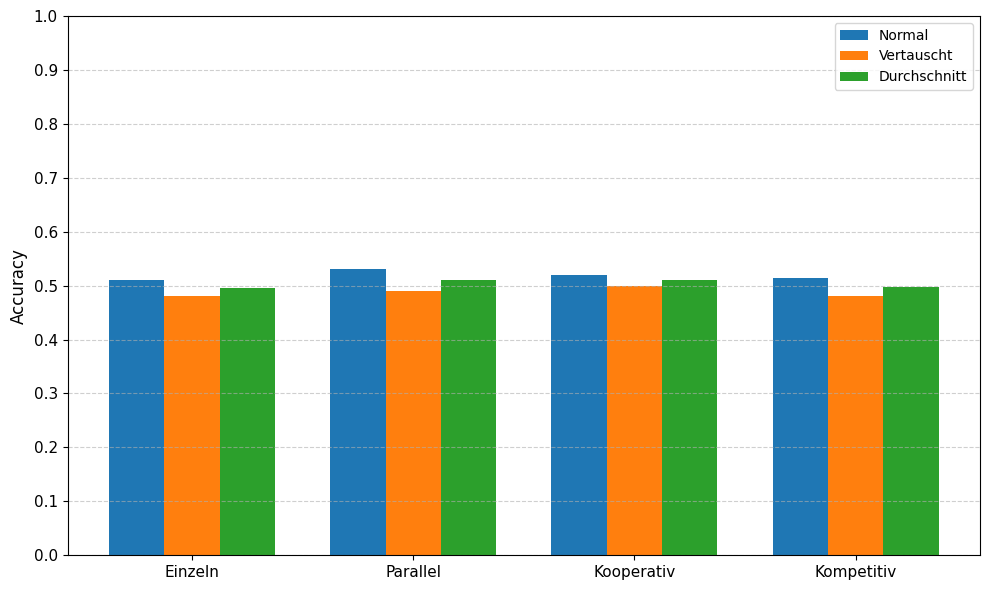

In [12]:
# Define German labels for the evaluation systems
system_labels_de = ["Einzeln", "Parallel", "Kooperativ", "Kompetitiv"]

# Extract accuracy values
acc_normal = summary_df["Accuracy (normal)"]
acc_swapped = summary_df["Accuracy (swapped)"]
acc_avg = summary_df["Accuracy (avg)"]

x = np.arange(len(system_labels_de))
bar_width = 0.25

plt.figure(figsize=(10, 6))

# Plot grouped bars for normal, swapped, and average accuracy
plt.bar(x - bar_width, acc_normal, width=bar_width, label="Normal")
plt.bar(x, acc_swapped, width=bar_width, label="Vertauscht")
plt.bar(x + bar_width, acc_avg, width=bar_width, label="Durchschnitt")

# Configure layout and axis labels
plt.xticks(x, system_labels_de, fontsize=11)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=11)  
plt.ylim(0, 1.0)
plt.ylabel("Accuracy", fontsize=12)
#plt.title("Vergleich der Accuracy der Bewertungssysteme (Normal / Vertauscht / Durchschnitt)", fontsize=13)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()


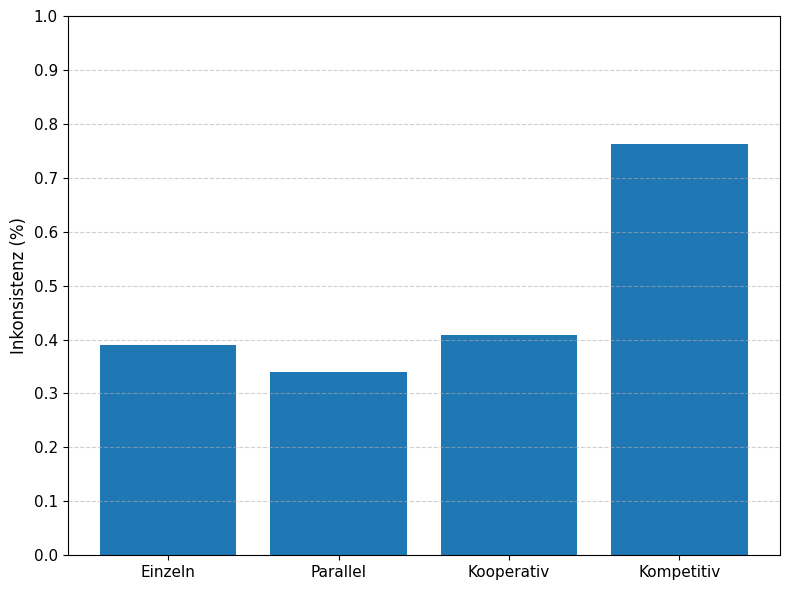

In [13]:
# Define German labels for the evaluation systems
system_labels_de = ["Einzeln", "Parallel", "Kooperativ", "Kompetitiv"]

# Extract inconsistency values
inconsistency = summary_df["Inconsistency"]

blue = plt.get_cmap("tab10")(0)

plt.figure(figsize=(8, 6))
bars = plt.bar(system_labels_de, inconsistency, color=blue)

# Configure layout and axis labels
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=11)
plt.xticks(fontsize=11)
plt.ylabel("Inkonsistenz (%)", fontsize=12)
#plt.title("Vergleich der Inkonsistenz der Bewertungssysteme bei vertauschter Antwortposition", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()

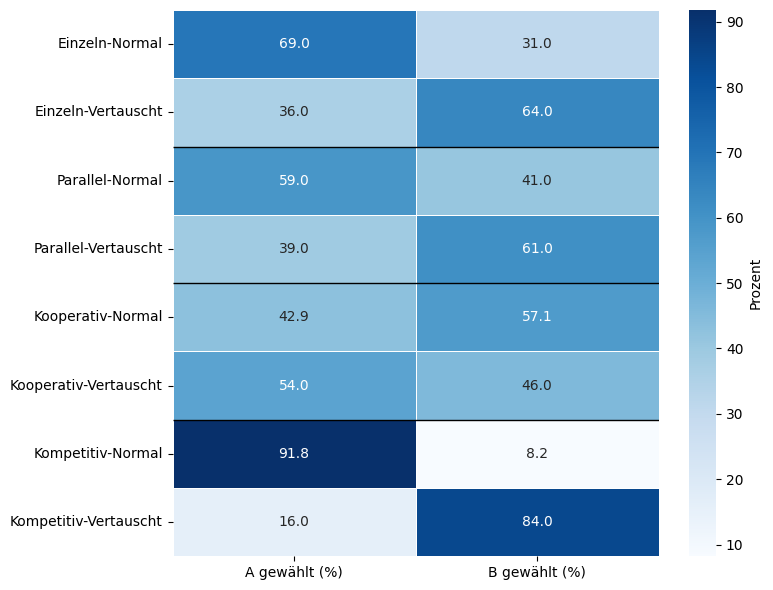

In [14]:
# Prepare bias data
bias_counts = []

# Mapping to German labels
system_labels_de = {
    "Single": "Einzeln",
    "Parallel": "Parallel",
    "Cooperative": "Kooperativ",
    "Competitive": "Kompetitiv"
}

# Filter valid decisions, count choices and store results
for system, dfs in data.items():
    for version in ["_1", "_2"]:
        df = dfs[version]
        valid = df[df["system_decision"].isin(["A", "B"])]
        count_A = (valid["system_decision"] == "A").sum()
        count_B = (valid["system_decision"] == "B").sum()
        total = count_A + count_B

        bias_counts.append({
            "System": system_labels_de[system],
            "Position": "Normal" if version == "_1" else "Vertauscht",
            "A gewählt (%)": round(100 * count_A / total, 1),
            "B gewählt (%)": round(100 * count_B / total, 1)
        })

bias_df = pd.DataFrame(bias_counts)

# Prepare heatmap data
heatmap_df = bias_df.set_index(["System", "Position"])[["A gewählt (%)", "B gewählt (%)"]]

# Adjust order for grouping
heatmap_df = heatmap_df.reindex([
    ("Einzeln", "Normal"), ("Einzeln", "Vertauscht"),
    ("Parallel", "Normal"), ("Parallel", "Vertauscht"),
    ("Kooperativ", "Normal"), ("Kooperativ", "Vertauscht"),
    ("Kompetitiv", "Normal"), ("Kompetitiv", "Vertauscht")
])

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={"label": "Prozent"},
    linewidths=0.5,
    linecolor="white"
)

# Add horizontal lines for separation
for i in range(2, len(heatmap_df), 2):
    ax.hlines(i, *ax.get_xlim(), colors="black", linewidth=1)

#plt.title("Verteilung der gewählten Antworten (A vs. B) pro System und Position", fontsize=13)
plt.ylabel("")
plt.tight_layout()
plt.show()